In [25]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

df = pd.read_csv("data/train.csv")

In [26]:
X = df.drop(["PassengerId", "Survived", "Name"], axis="columns")
y = df["Survived"]

In [27]:
X_enc = pd.get_dummies(X, columns = ["Pclass", "Sex", "Embarked"])

has_cabin = [int(pd.isna(cabin)) for cabin in X_enc["Cabin"]]
X_enc["has cabin"] = has_cabin


#X_enc["deck"] = X_enc["Cabin"].str.get(0)
#X_enc = pd.get_dummies(X_enc, columns=["deck"])


#on_c_deck = [int(deck == 'F') for deck in X_enc["deck"]]
#X_enc["on F"] = on_c_deck

X_enc = X_enc.drop(["Cabin", "Ticket"], axis = "columns")
X_enc.head()


,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,has cabin
0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1,1
1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0,0
2,26.0,0,0,7.9250,0,0,1,1,0,0,0,1,1
3,35.0,1,0,53.1000,1,0,0,1,0,0,0,1,0
4,35.0,0,0,8.0500,0,0,1,0,1,0,0,1,1


In [28]:
imputer = SimpleImputer(missing_values=pd.NA, strategy="median")
X_enc["Age"] = imputer.fit_transform(np.array(X_enc["Age"]).reshape(-1,1))

In [29]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC())
])

X_train, X_test, y_train, y_test = train_test_split(X_enc, y, random_state=22)

In [30]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

svc_parameters = {
    "svc__kernel": ["rbf"],
    "svc__gamma": ["scale", "auto", 0.01, 0.1, 0.06, 0.07, 0.08],
    "svc__C": [0.01, 0.1, 1, 2, 2.5, 3, 4, 5],
    "svc__class_weight": [None, "balanced"]
}

opt = GridSearchCV(estimator=pipe, param_grid=svc_parameters, cv=10, scoring="accuracy")
opt.fit(X_train, y_train)
opt.best_params_

{'svc__C': 4,
 'svc__class_weight': None,
 'svc__gamma': 0.08,
 'svc__kernel': 'rbf'}

In [31]:
accuracy_score(y_test, opt.predict(X_test))

0.7802690582959642

0.7937219730941704


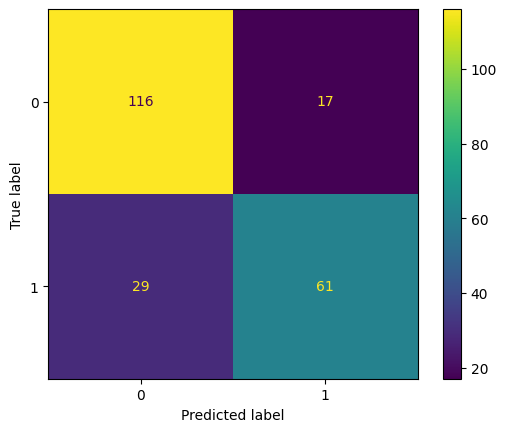

In [32]:
pipe.fit(X_train, y_train)
predictions = pipe.predict(X_test)

print(accuracy_score(y_test, predictions))
ConfusionMatrixDisplay(confusion_matrix(y_test, predictions)).plot()

In [33]:
from sklearn.ensemble import RandomForestClassifier

forest_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("forest", RandomForestClassifier())
])

forest_grid = {
    "forest__n_estimators": [50, 100, 150, 200],
    "forest__max_depth": [3, 5, 7, None],
    "forest__criterion": ["gini", "entropy"],
}

forcv = GridSearchCV(estimator=forest_pipe, param_grid=forest_grid, cv = 10, scoring="accuracy")

forcv.fit(X_train, y_train)
forcv.best_params_

{'forest__criterion': 'gini',
 'forest__max_depth': 5,
 'forest__n_estimators': 200}

In [34]:
forpred = forcv.predict(X_test)
accuracy_score(y_test, forpred)

0.7847533632286996

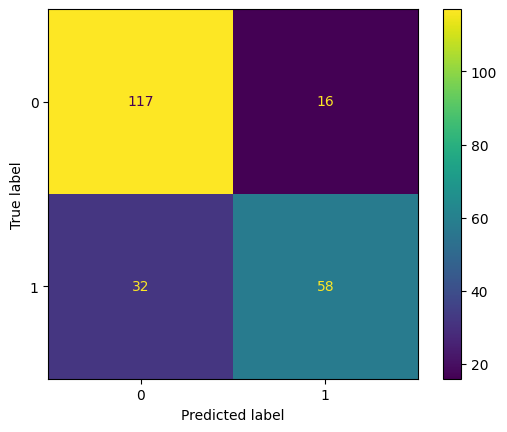

In [35]:
ConfusionMatrixDisplay(confusion_matrix(y_test, forpred)).plot()